<center><img src="../themes/aequitas_logo.png"/></center>
<center><figcaption>Fig.1 - Logo d'Aequitas</figcaption></center>

# 1. Introduction

**Aequitas** est un outil open-source d'audit de biais et de discrimination dans les modèles de machine learning.

## 1.1. Interface
Aequitas peut être utilisé via trois interfaces.
- Un **[package python](https://dssg.github.io/aequitas/using_python.html)**
- Une **[interface web](https://dssg.github.io/aequitas/30_seconds_webapp.html)** qui peut être utilisée soit à partir du site d'Aequitas soit localement.
- Une **[CLI](https://dssg.github.io/aequitas/CLI.html)**

Alors que les trois interfaces permettent de mener le même type d'analyse, la CLI et l'interface web permettent de générer des rapports d'analyse de biais très rapidement. Le package python est très pratique lors d'une analyse exploratoire du biais et lors de l'interaction avec d'autres packages.

Dans ce notebook, seules les fonctionnalités du package python seront présentées.

## 1.2. Données d'entrée

Pour le moment, Aequitas permet de mener des analyses seulement dans le cas de problématiques de **classification binaire**. 

En données d'entrée, Aequitas s'attend au moins à deux colonnes:

- **score**: Cette colonne doit correspondre à la sortie du modèle. 
    - Elle peut prendre comme valeur soit des **0/1 ou des probabilités**. 
    - En cas de probabilités, l'utilisateur doit fournir le seuil permettant de séparer les deux classes.
- **attribute**: Cette colonne correspond à la variable sensible. 
    - Aequitas permet d'analyser le biais avec **plusieurs variables sensibles** à la fois et *plusieurs colonnes* peuvent donc être fournies en entrée.
    - Aequitas ne prend que **des variables à protéger catégorielles**.
    - Les variables sensibles dépendent du cadre réglementaire et du contexte de l'analyse mais l'âge et le sexe sont des exemples de variables qui sont souvent considérées comme variables à protéger.
- **label_value**: correspond à la valeur réelle (ground-truth) de de l'output. Cette colonne n'est pas obligatoire mais le fait de la fournir permet de calculer plusieurs métriques en plus.


Mots réservés dans Aequitas: *score*, *label_value*, *id*, *model_id*, *entity_id*, *rank_abs* et *rank_pct*.

<center><img src="../themes/python_input.jpg"/></center>
<center><figcaption>Fig.2 - Données d'entrée pour Aequitas</figcaption></center>

## 1.3. Structure d'Aequitas

Aequitas contient 4 classes. Chacune de ces 4 classes a un rôle spécifique.

Dans la pratique, les trois classes suivantes sont utilisées l'une à la suite de l'autre.
- `Group`: Cette classe permet de **définir les variables à protéger** et de **calculer les métriques** de groupe dessus.
- `Bias`: Cette classe **calcule les disparités** entre les différents groupes, et ce à partir des résultats des métriques calculées par les méthodes de la classe `Group`.
- `Fairness`: Cette classe permet de **définir la mesure d'équité** et indique si la définition est respectée par l'output du modèle.

La dernière classe, en l'occurrence `Plot` contient plusieurs fonctions qui permettent d'obtenir rapidement **des visualisations adaptées** à l'output de chacune des classes ci-dessus.

# 2. Cas pratique - COMPAS

## 2.1. Contexte

**Disclaimer: Alors que l'analyse du dataset issu de l'outil COMPAS est un usecase classique dans l'analyse des biais des modèles, cet exemple s'inspire beaucoup de la documentation d'Aequitas ainsi que de plusieurs présentations de l'équipe d'Aequitas.**

*COMPAS* est un outil d'évaluation de risques d'individus qui est utilisé dans plusieurs états aux Etats-Unis. Le but de l'outil est d'évaluer les risques que peuvent présenter les individus et d'aider ainsi les juges à prendre **certains types de décisions** telle que la possibilité de mise en liberté provisoire sous caution.

En 2016, ProPublica a mené une investigation de l'impact de COMPAS et des biais qu'il présente. Pour plus d'éléments sur l'analyse menée par ProPublica du modèle utilisé dans l'outil COMPAS, n'hésitez pas à consulter:
- [Machine Bias: Risk Assessments in Criminal Sentencing](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)
- [Le dépôt github de l'analyse de ProPublica](https://github.com/propublica/compas-analysis)

<br>
<center><img src="../themes/propublica_article_fig.jpeg" width="500" height="auto"/></center>
<center><figcaption>Fig.3 - Bernard Parker, à gauche, évalué risque élevé; Dylan Fugett évalué risque bas</figcaption></center>


<center><a href="https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing">Source: ProPublica</a></center>


## 2.2. Jeu de données

COMPAS produit un score qui correspond au **risque de récidivisme**. Ce risque correspond au risque de commettre un crime dans les deux ans qui suivent.


Le **résultat de COMPAS** correspond à un score qui va de 1 à 10. Dans ce cas pratique, ce score a été converti à un score binaire, avec:
- Score de 0: Risque de récidivisme bas
- Score de 1: Risque de récidivisme élevé

Les **variables à protéger** dans ce cas pratique sont l'*âge*, le *sexe* et l'*origine ethnique*.

Le jeu de données à disposition est issu du dépôt Github d'Aequitas et est déjà dans le bon format pour Aequitas.

In [44]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

In [23]:
project_path = Path("..")
data_path = project_path/"datasets"

In [26]:
df_compas = pd.read_csv(data_path/"compas_for_aequitas.csv")
df_compas.head()

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45


# 2.3. Analyse exploratoire

Dans un premier temps, une analyse des distributions des modalités des différentes variables à protéger peut révéler plusieurs pistes/hypothèses à explorer. Cette analyse est loin d'être exhaustive.

**Croisement de l'origine avec le score du modèle**

<AxesSubplot:xlabel='race'>

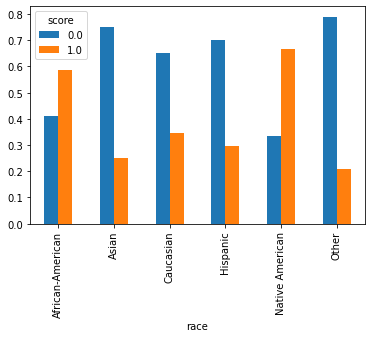

In [42]:
# Croisement origine ethnique - Score du modèle
(
    pd.crosstab(df_compas.race, df_compas.score, normalize="index")
    .plot.bar()
)

**Croisement du sexe avec le score du modèle**

<AxesSubplot:xlabel='sex'>

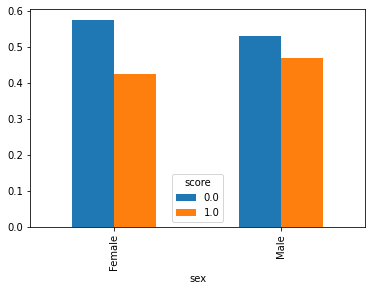

In [52]:
# Croisement Sexe - Score du modèle
(
    pd.crosstab(df_compas.sex, df_compas.score, normalize="index")
    .plot.bar()
)

**Croisement de la tranche d'âge avec le score du modèle**

<AxesSubplot:xlabel='age_cat'>

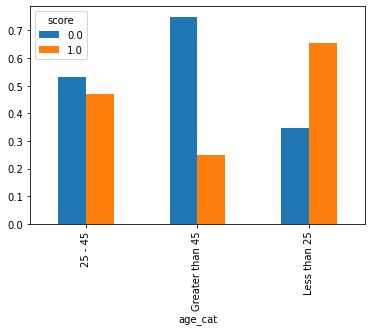

In [54]:
# Croisement Tranche d'âge - Score du modèle
(
    pd.crosstab(df_compas.age_cat, df_compas.score, normalize="index")
    .plot.bar()
)